In [1]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import utils
from snntorch import surrogate
import torch.nn.functional as F
from snntorch import functional as SF
import brevitas.nn as qnn 
from tqdm import tqdm
from pathlib import Path

import sys
sys.path.append('../src')
from networks_debug_state_quant import *
from dataloader import WisdmDatasetParser, WisdmDataset
from torch.utils.data import  DataLoader
from assistant import Assistant
from stats import LearningStats
from utils import *

In [2]:

#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = 'cuda'
print(f'Using device {device}')

Using device cuda


In [3]:
batch_size = 512
slope = 10
# network parameters
num_inputs = 6 
num_steps = 40
net_hidden_1 = 180
net_hidden_2 = 400
net_hidden_3 = 128
num_outputs = 7
pop_outputs = num_outputs * 10
num_epochs = 200
vth_in = 1.0
vth_out = 1.0
vth_recurrent = 1.0
vth_enc_value =  1.0
vth_std =  65 
beta_in = 0.5
beta_recurrent = 0.5
beta_back = 0.6
beta_out = 0.5
encoder_dim = 25
beta_std = 55
lr = 0.002
drop_recurrent =0.15
drop_back = 0.15
drop_out = 0.15
# spiking neuron parameters
beta = 0.8  # neuron decay rate


In [4]:
DATASET_NAME = 'data_watch_subset_0_40.npz'
DATASET_SUBSET = 'custom'
SUBSET_LIST = [0, 4, 6, 8, 9, 10, 14]
PATIENCE = 1
TRAIN_FOLDER_NAME = 'Trained'
NUM_WORKERS = 8
NET_OUTPUT_DIM = 7
NET_INPUT_DIM = 6
NUM_EPOCHS = 1
SEARCH_SPACE_SHUFFLE = 200

(6,)
(6,)
ytrain shape (55404, 18)
yval shape (18468, 18)
ytest shape (18469, 18)
num classes train dataset: 7 occurrences of each class:[3127 3044 3102 3047 3150 3087 2973]
num classes eval dataset: 7 occurrences of each class:[1035 1048 1122  996 1110 1053 1007]
num classes test dataset: 7 occurrences of each class:[1046 1048 1046 1036 1076 1026  982]
Using device cuda


/home/franzhd/miniconda3/envs/snn_torch/lib/python3.10/site-packages/brevitas/nn/mixin/base.py:77: UserWarning: Keyword arguments are being passed but they not being used.
  warn('Keyword arguments are being passed but they not being used.')
  0%|          | 0/43 [00:00<?, ?it/s]/home/franzhd/miniconda3/envs/snn_torch/lib/python3.10/site-packages/torch/_tensor.py:1413: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1925.)
  return super().rename(names)
/home/franzhd/miniconda3/envs/snn_torch/lib/python3.10/site-packages/snntorch/_neurons/neurons.py:399: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  arg = torch.zeros_like(inp

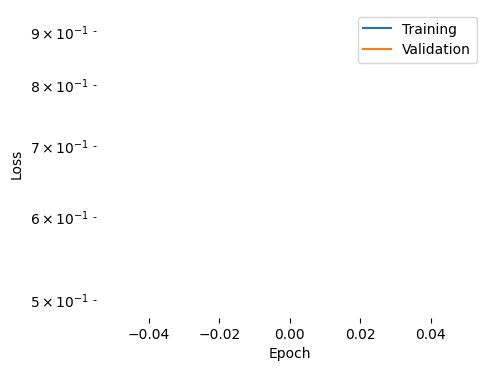

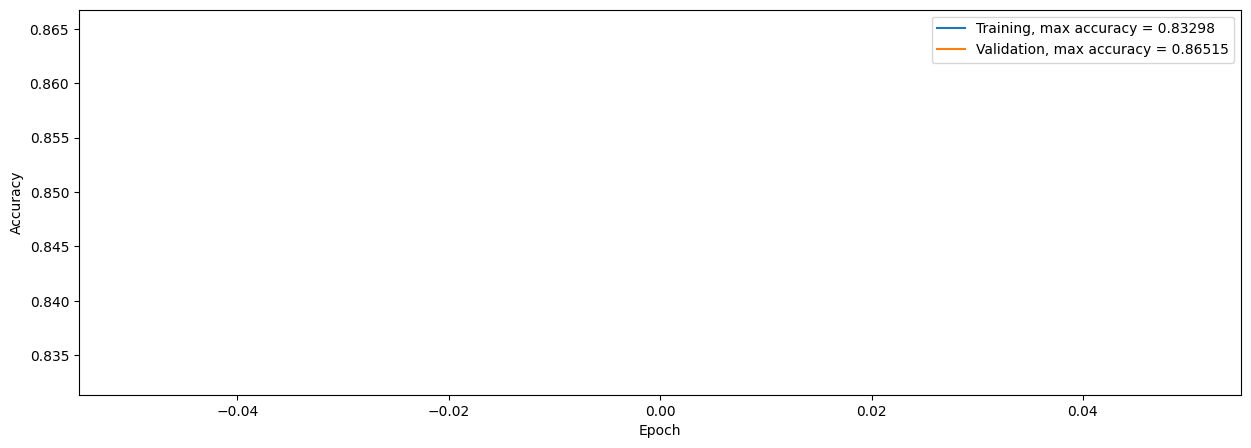

In [5]:
trained_folder = TRAIN_FOLDER_NAME
os.makedirs(trained_folder, exist_ok=True)
dataset = WisdmDatasetParser(f'{Path.home()}/snntorch_network/data/{DATASET_NAME}', norm=None, class_sublset=DATASET_SUBSET, subset_list=SUBSET_LIST)
val_set = dataset.get_validation_set()
train_set = dataset.get_training_set()

val_dataset = WisdmDataset(val_set)
train_dataset = WisdmDataset(train_set)

val_loader  = DataLoader(dataset= val_dataset, batch_size=int(batch_size), shuffle=True, num_workers=NUM_WORKERS)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f'Using device {device}')

grad = surrogate.fast_sigmoid(slope) #use slope for HPO

net_loss = regularization_loss(0.1, 0.03, 40)

net = QuantAhpcNetwork(NET_INPUT_DIM, int(net_hidden_1), int(net_hidden_2), NET_OUTPUT_DIM, grad,vth_back=1.0,
                    vth_in=vth_in, vth_recurrent=vth_recurrent, vth_out=vth_out,
                    beta_in=beta_in, beta_recurrent=beta_recurrent, beta_back=beta_back, beta_out=beta_out,
                    # encoder_dim=int(encoder_dim),
                    # vth_enc_value=vth_enc_value, vth_std=vth_std, beta_std=beta_std,
                    drop_recurrent=drop_recurrent, drop_back=drop_back, drop_out=drop_out,
                    time_dim=2, layer_loss=net_loss, state_quant=False).to(device)
net.from_npz(f'/home/franzhd/snntorch_network/notebook/Trained_8w_16nin_conn_no_quant/network_best.npz')
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
    T_max=4690, 
    eta_min=0, 
    last_epoch=-1
)

loss_fn = SF.loss.ce_count_loss()

stats = LearningStats()
assistant = Assistant(net, loss_fn, optimizer, stats, classifier=True, scheduler=scheduler, lam=1.0)


count = 0
for epoch in range(NUM_EPOCHS):
    labels = []
    outputs = []
    # if epoch % 20 == 0:
    #     assistant.reduce_lr()
    if count < PATIENCE:
        count = count+1
        tqdm_dataloader = tqdm(train_loader)
        for _, batch in enumerate(tqdm_dataloader): # training loop
            input, label = batch
            
            output = assistant.train(input, label)
            tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{NUM_EPOCHS}] Training: {stats.training}')

        tqdm_dataloader = tqdm(val_loader)
        for _, batch in enumerate(tqdm_dataloader): #eval loop
            input, label = batch
            output = assistant.valid(input, label)
            tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{NUM_EPOCHS}] Validation: {stats.validation}')
        
            if len(outputs) == 0:
                outputs = output.to('cpu').detach()
                labels = label.to('cpu').detach()
            else:
                outputs = torch.cat((outputs, output.to('cpu').detach()), dim=1)
                labels = torch.cat((labels, label.to('cpu').detach()))

        stats.update()

        if stats.validation.best_accuracy:
            count = 0
            _, predictions = outputs.sum(dim=0).max(1)
            gen_confusion_matrix(predictions,labels, f'./{trained_folder}/')
            net.save_to_npz(f'./{trained_folder}/network_best.npz')
            stats.plot(figsize=(15, 5),path=f'./{trained_folder}/')
            stats.save( f'./{trained_folder}/')
            del predictions

        del outputs
        del labels
        
        torch.cuda.empty_cache()
stats.plot(figsize=(15, 5),path=f'./{trained_folder}/')
stats.save( f'./{trained_folder}/')


In [6]:
print(net.linear1.weight)
print(net.linear1.weight.dtype)
print(net.linear1.quant_weight_scale()) 
print(net.linear1.quant_weight_zero_point())

Parameter containing:
tensor([[ 0.0179, -0.0286,  0.0243, -0.5063,  0.2557, -0.2330],
        [-0.1068,  0.1284, -0.0288, -0.3226,  0.5380, -0.4391],
        [-0.0794, -0.0535,  0.0237,  0.0131,  0.0156, -0.0260],
        ...,
        [ 0.0503,  0.0200,  0.1023,  0.1463,  0.0816,  0.0073],
        [-0.1004,  0.2908, -0.0764,  0.0529,  0.2683, -0.4398],
        [-0.0351,  0.1156, -0.1027, -0.3292,  0.3239,  0.2886]],
       device='cuda:0', requires_grad=True)
torch.float32
tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0., device='cuda:0')


In [7]:
print(net.linear2.weight)
print(net.linear2.weight.dtype)

Parameter containing:
tensor([[ 0.1808, -0.0197,  0.0714,  ..., -0.0410,  0.0683,  0.0209],
        [ 0.1003, -0.0864, -0.0379,  ..., -0.0126,  0.0215,  0.0508],
        [ 0.0579, -0.0895, -0.0419,  ...,  0.0209,  0.0018, -0.0233],
        ...,
        [-0.0414,  0.0017,  0.1374,  ...,  0.0846,  0.0340, -0.2367],
        [ 0.1716,  0.0821, -0.0106,  ...,  0.0315, -0.0844, -0.0926],
        [ 0.1912, -0.0959, -0.0589,  ..., -0.0626, -0.1264, -0.2349]],
       device='cuda:0', requires_grad=True)
torch.float32


In [8]:
print(net.linear2.quant_weight().value)

tensor([[ 0.1797, -0.0234,  0.0703,  ..., -0.0391,  0.0703,  0.0234],
        [ 0.1016, -0.0859, -0.0391,  ..., -0.0156,  0.0234,  0.0547],
        [ 0.0547, -0.0859, -0.0391,  ...,  0.0234,  0.0000, -0.0234],
        ...,
        [-0.0391,  0.0000,  0.1406,  ...,  0.0859,  0.0312, -0.2344],
        [ 0.1719,  0.0859, -0.0078,  ...,  0.0312, -0.0859, -0.0938],
        [ 0.1875, -0.0938, -0.0625,  ..., -0.0625, -0.1250, -0.2344]],
       device='cuda:0', grad_fn=<MulBackward0>)


In [9]:
print(net.leaky2.beta.data)
print(net.leaky2.threshold.data)
print(net.leaky1.beta.data)
print(net.leaky1.threshold.data)
print(net.recurrent.beta.data)
print(net.recurrent.threshold.data)

tensor(1.0030, device='cuda:0')
tensor(0.8804, device='cuda:0')
tensor(0.3577, device='cuda:0')
tensor(1.6035, device='cuda:0')
tensor(0.8133, device='cuda:0')
tensor(0.8978, device='cuda:0')


In [10]:
net.from_npz(f'./{trained_folder}/network_best.npz')
net.to(device)


QuantAhpcNetwork(
  (linear1): QuantLinear(
    in_features=6, out_features=180, bias=False
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (extra_tracked_params_list): ModuleList(
              (0-3): 4 x _ViewCatParameterWrapper(
                (view_sh

In [11]:
print(net.linear1.weight)
print(net.linear1.weight.dtype)
print(net.linear1.quant_weight_scale()) 
print(net.linear1.quant_weight_zero_point())

Parameter containing:
tensor([[ 0.0179, -0.0286,  0.0243, -0.5063,  0.2557, -0.2330],
        [-0.1068,  0.1284, -0.0288, -0.3226,  0.5380, -0.4391],
        [-0.0794, -0.0535,  0.0237,  0.0131,  0.0156, -0.0260],
        ...,
        [ 0.0503,  0.0200,  0.1023,  0.1463,  0.0816,  0.0073],
        [-0.1004,  0.2908, -0.0764,  0.0529,  0.2683, -0.4398],
        [-0.0351,  0.1156, -0.1027, -0.3292,  0.3239,  0.2886]],
       device='cuda:0', requires_grad=True)
torch.float32
tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0., device='cuda:0')


In [12]:
print(net.linear2.quant_weight().value)

tensor([[ 0.1797, -0.0234,  0.0703,  ..., -0.0391,  0.0703,  0.0234],
        [ 0.1016, -0.0859, -0.0391,  ..., -0.0156,  0.0234,  0.0547],
        [ 0.0547, -0.0859, -0.0391,  ...,  0.0234,  0.0000, -0.0234],
        ...,
        [-0.0391,  0.0000,  0.1406,  ...,  0.0859,  0.0312, -0.2344],
        [ 0.1719,  0.0859, -0.0078,  ...,  0.0312, -0.0859, -0.0938],
        [ 0.1875, -0.0938, -0.0625,  ..., -0.0625, -0.1250, -0.2344]],
       device='cuda:0', grad_fn=<MulBackward0>)


In [13]:
labels = []
outputs = []

tqdm_dataloader = tqdm(val_loader)
for _, batch in enumerate(tqdm_dataloader): #eval loop
    input, label = batch
    output = assistant.valid(input, label)
    tqdm_dataloader.set_description(f'\r Validation: {stats.validation}')

    if len(outputs) == 0:
        outputs = output.to('cpu').detach()
        labels = label.to('cpu').detach()
    else:
        outputs = torch.cat((outputs, output.to('cpu').detach()), dim=1)
        labels = torch.cat((labels, label.to('cpu').detach()))

stats.update()

if stats.testing.best_accuracy:
    count = 0
    _, predictions = outputs.sum(dim=0).max(1)
    gen_confusion_matrix(predictions,labels, f'./{trained_folder}/')
    net.save_to_npz(f'./{trained_folder}/network_best.npz')
    stats.save( f'./{trained_folder}/')
    stats.plot(path=f'./{trained_folder}/')
    del predictions
del labels
del outputs

torch.cuda.empty_cache()


  0%|          | 0/15 [00:00<?, ?it/s]/home/franzhd/miniconda3/envs/snn_torch/lib/python3.10/site-packages/snntorch/_neurons/neurons.py:399: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  arg = torch.zeros_like(input_, requires_grad=True)
/home/franzhd/snntorch_network/notebook/../src/RecurrentAHPC_debug.py:125: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  base_fn = self.beta.clamp(0, 1) * mem + input_ - self.recurrent(spk)
/home/franzhd/miniconda3/envs/snn_torch/lib/python3.10/site-packages/snntorch/_neurons/leaky.py:211: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please 

TypeError: '<' not supported between instances of 'NoneType' and 'float'